In [1]:
import numpy as np
import msprime, tskit
import COPYtest_extend_edges as ee
from IPython.display import SVG

In [3]:
def total_extend(ts, max_iter):
    talbes = ts.dump_tables()
    mutations = tables.mutations.copy()
    tables.mutations.clear()

    last_num_edges = ts.num_edges
    for _ in range(max_iter):
        for func in [_extend_edges, _extend_paths]:
            for forwards in [True, False]:
                edges = ee.func(ts, forwards = forwards)
                tables.edges.replace_with(edges)
                tables.sort()
                tables.build_index()
                ts = tables.tree_sequence()

            if ts.num_edges == last_num_edges:
                break
            else:
                last_num_edges = ts.num_edges
    tables = ts.dump_tables()
    mutations = ee._slide_matations_ndoes_up(ts, mutations)
    tables.mutations.replace_with(mutations)
    tables.edges.squash()
    tables.sort()
    ts = tables.tree_sequence()

    return ts     

#### Check convergence between EE -> EP .vs. EP -> EE

In [13]:
samples = 50
ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 1e6, record_full_arg = True, random_seed = 73,
                             recombination_rate = 1e-8)
sts = ts.simplify()
old_num_edges = 0
k = 0
print('simplified num edges', sts.num_edges)
while k < 10 and sts.num_edges != old_num_edges:
    old_num_edges = sts.num_edges
    ext = ee.extend_edges(sts)
    print('extend edges', ext.num_edges)
    eext = ee.extend_paths(ext)
    print('extend paths', eext.num_edges)
    sts = eext

simplified num edges 857
extend edges 585
extend paths 616
extend edges 561
extend paths 570
extend edges 552
extend paths 552
extend edges 552
extend paths 552


In [15]:
sts = ts.simplify()
old_num_edges = 0
k = 0 
print('simplified num edges', sts.num_edges)
while k < 10 and sts.num_edges != old_num_edges:
    old_num_edges = sts.num_edges
    epts = ee.extend_paths(sts)
    print('extend paths', epts.num_edges)
    eets = ee.extend_edges(epts)
    print('extend edges', eets.num_edges)
    sts = eets

simplified num edges 857
extend paths 746
extend edges 567
extend paths 581
extend edges 551
extend paths 553
extend edges 550
extend paths 550
extend edges 550


In [51]:
# eets.tables.assert_equals(eext.tables, ignore_provenance = True)

## Uh oh.

In [33]:
eext.tables.edges[485], eets.tables.edges[485]

(EdgeTableRow(left=698546.0, right=817047.0, parent=313, child=310, metadata=b''),
 EdgeTableRow(left=707409.0, right=817047.0, parent=313, child=310, metadata=b''))

## Attention to Edge 313 --> 310

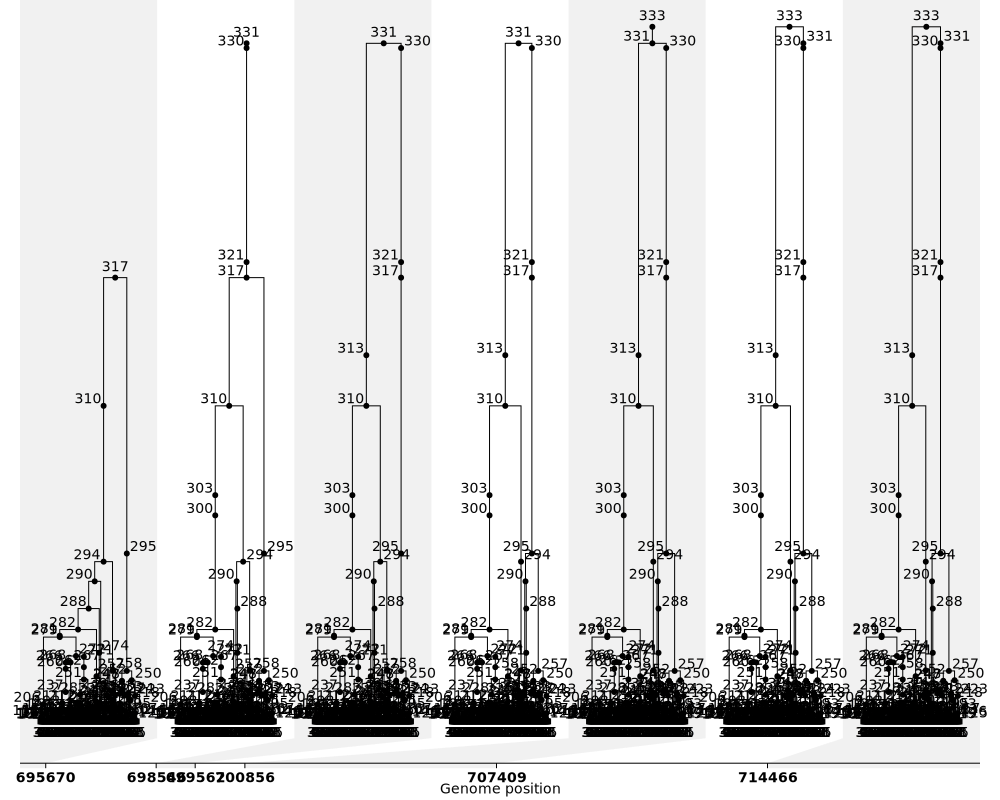

In [55]:
SVG(eext.draw_svg(x_lim = [695000,720000],size = (1000,800)))

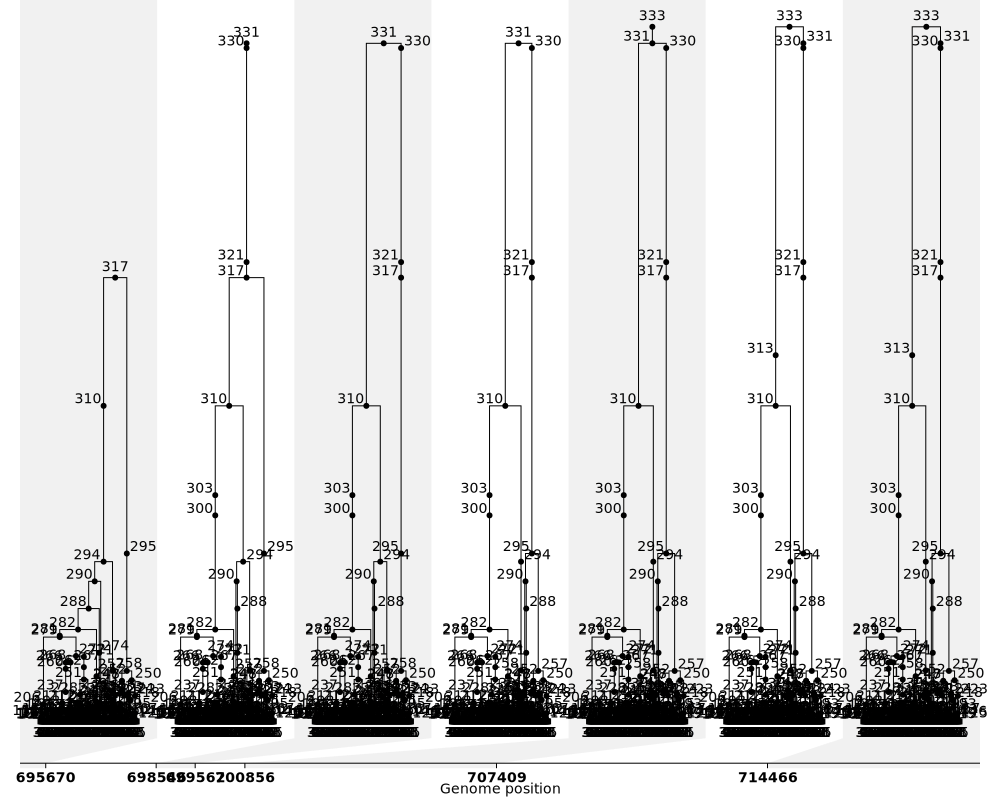

In [54]:
SVG(eets.draw_svg(x_lim = [695000,720000],size = (1000,800)))

## Notes on the difference between these Tree Sequences
`eets.num_edges = 550` This was made with $EP \to EE$.
`eext.num_edges = 552` This was made with $EE \to EP$.

EEXT extended the edge $ 313 \to 310 $ further to the left (left = 698546) than EETS (left = 707409).

For both tree sequences the only way this edge could be further extended is if we extend via `extend_paths`. EETS does not extend the edge $ 313 \to 310 $ further and I believe this is because the `outparent[313]` is a root. We try and not involve roots in the extension because it is complicated, however we may want to try and do so to improve the algorithm and make it symmetric (ie. $ EE \to EP \cong EP \to EE$).


#### Current `merge_edge_paths` for problem edge $ 313 \to 310 $ on $EETS$.

`forwards = False`, Assume `path_check = False` for all current nodes involved in construction.
$ 333 \to 310 $ in `edges_in`.

`c = 310`

`p_in = 331`

`p_out = 313`

`ipp = [310, 331]`

`opp = [310, 313, 333]`

Note that that `ipp` $\cap$ `opp` = `[310]` and so no path is extended. However if we continued to construct `ipp` a bit further we would have `ipp = [310, 331, 333]` which would contruct the path. However, this violates our "no paths through branch points rule" as it could break the algorithm and add potentially incorrect nodes in parts of the tree sequence.

### Thoughts on fixing the issue or making choice.

Currently I cannot think of a sure-fire way to correct this. 

Some ides could be perhaps do something like the following:

Construct `ipp` first. Then construct `opp`.

If |`ipp` $ \cap $ `opp`| = 1:

` if nodes_edge[ipp[-1]] == opp[-1] :`
Then `ipp.append(opp[-1])`.

Doing this for the above example would yield path:
`[310, 313, 331, 333]`

and this would properly extend the edge $313 \to 310$.

Currently, I am assuming that this would break the algorithm; it will certainly make it slower.

# YOLO. 
I edited `merge_edge_paths` with the above fix. Will it break??

In [4]:
samples = 50
ts = msprime.sim_ancestry(samples, population_size = 1000, sequence_length = 1e6, record_full_arg = True, random_seed = 73,
                             recombination_rate = 1e-8)
sts = ts.simplify()
old_num_edges = 0
k = 0
print('simplified num edges', sts.num_edges)
while k < 10 and sts.num_edges != old_num_edges:
    old_num_edges = sts.num_edges
    ext = ee.extend_edges(sts)
    print('extend edges', ext.num_edges)
    eext = ee.extend_paths(ext)
    print('extend paths', eext.num_edges)
    sts = eext
    k+=1

simplified num edges 857
extend edges 585
extend paths 616
extend edges 561
extend paths 570
extend edges 552
extend paths 552
extend edges 552
extend paths 552


In [6]:
sts = ts.simplify()
old_num_edges = 0
k = 0 
print('simplified num edges', sts.num_edges)
while k < 10 and sts.num_edges != old_num_edges:
    old_num_edges = sts.num_edges
    epts = ee.extend_paths(sts)
    print('extend paths', epts.num_edges)
    eets = ee.extend_edges(epts)
    print('extend edges', eets.num_edges)
    sts = eets
    k+=1

simplified num edges 857
extend paths 746
extend edges 567
extend paths 583
extend edges 552
extend paths 555
extend edges 552


In [7]:
eets.tables.assert_equals(eext.tables, ignore_provenance = True)

AssertionError: EdgeTable row 137 differs:
self.left=648009.0 other.left=953785.0

In [15]:
eets.tables.edges[137], eext.tables.edges[137]

(EdgeTableRow(left=648009.0, right=1000000.0, parent=168, child=51, metadata=b''),
 EdgeTableRow(left=953785.0, right=1000000.0, parent=168, child=51, metadata=b''))

In [13]:
tskit.set_print_options(max_lines = 150)
eets.tables.edges[130:140]

id,left,right,parent,child,metadata
0,0,1000000,164,160,
1,0,1000000,165,139,
2,0,1000000,165,149,
3,0,648009,166,51,
4,0,1000000,166,157,
5,0,1000000,167,47,
6,0,1000000,167,57,
7,648009,1000000,168,51,
8,972680,1000000,168,133,
9,739952,1000000,169,19,


In [14]:
eext.tables.edges[130:140]

id,left,right,parent,child,metadata
0,0,1000000,164,160,
1,0,1000000,165,139,
2,0,1000000,165,149,
3,0,648009,166,51,
4,0,1000000,166,157,
5,0,1000000,167,47,
6,0,1000000,167,57,
7,953785,1000000,168,51,
8,972680,1000000,168,133,
9,739952,1000000,169,19,


In [36]:
t = eext.at(953233)
t.depth(207), t.depth(51)

(7, 12)

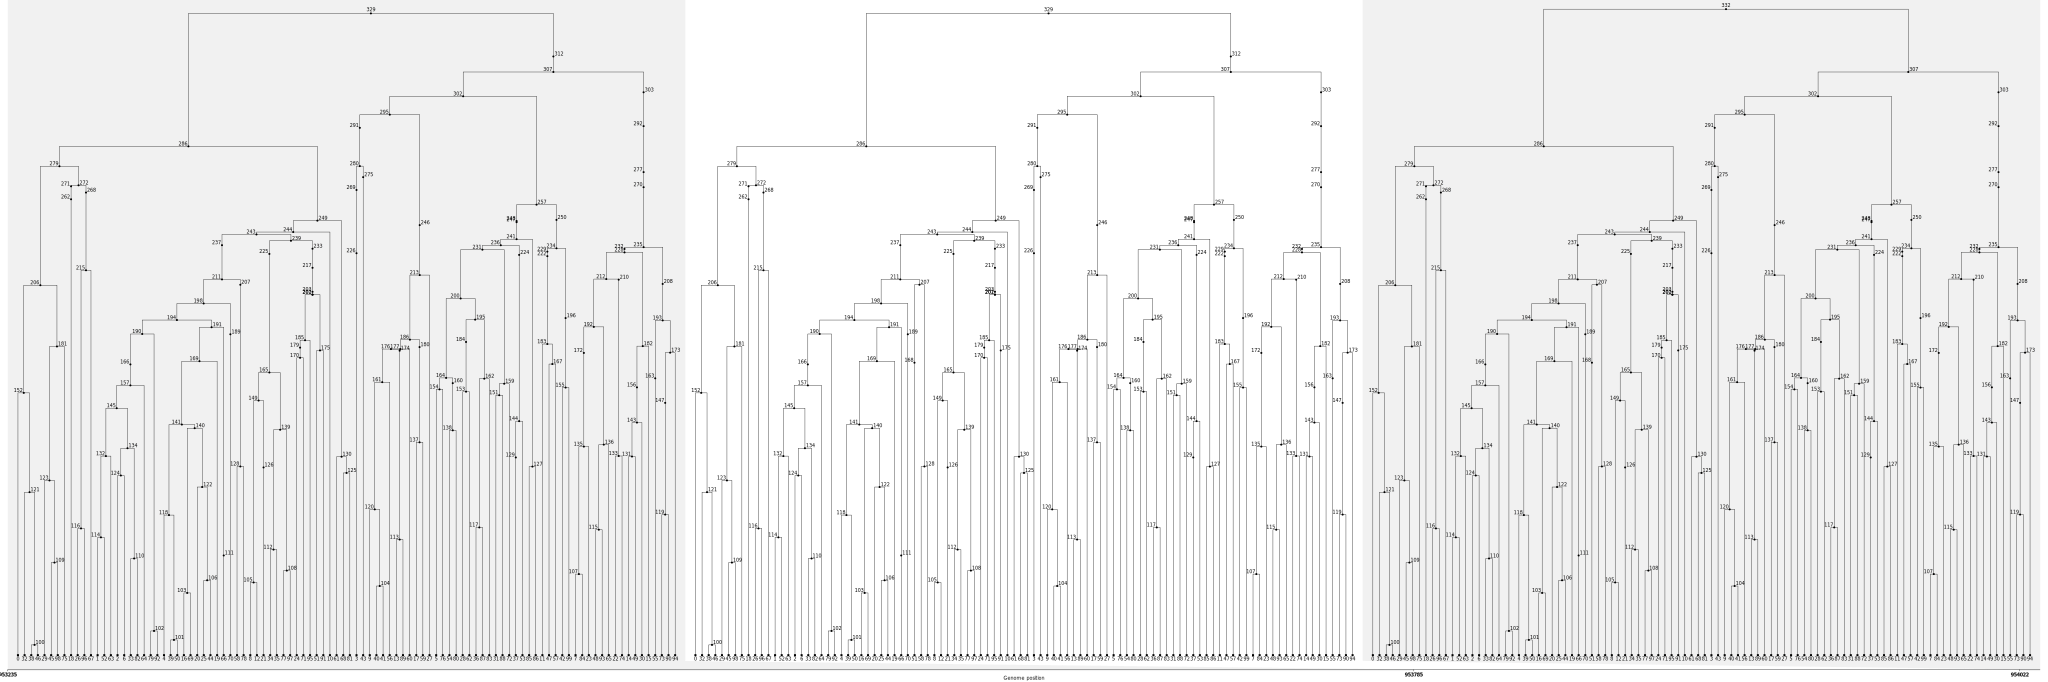

In [39]:
SVG(eext.draw_svg(x_lim = [953235,954030],size = (6000,2000), time_scale = 'log_time'))

$168$ is unary on $[953785, 954022]$. It has path $207 \to 168 \to 51$.

$168$ is unary on $[953235,953785]$. It has path $207 \to 168 \to 51$.




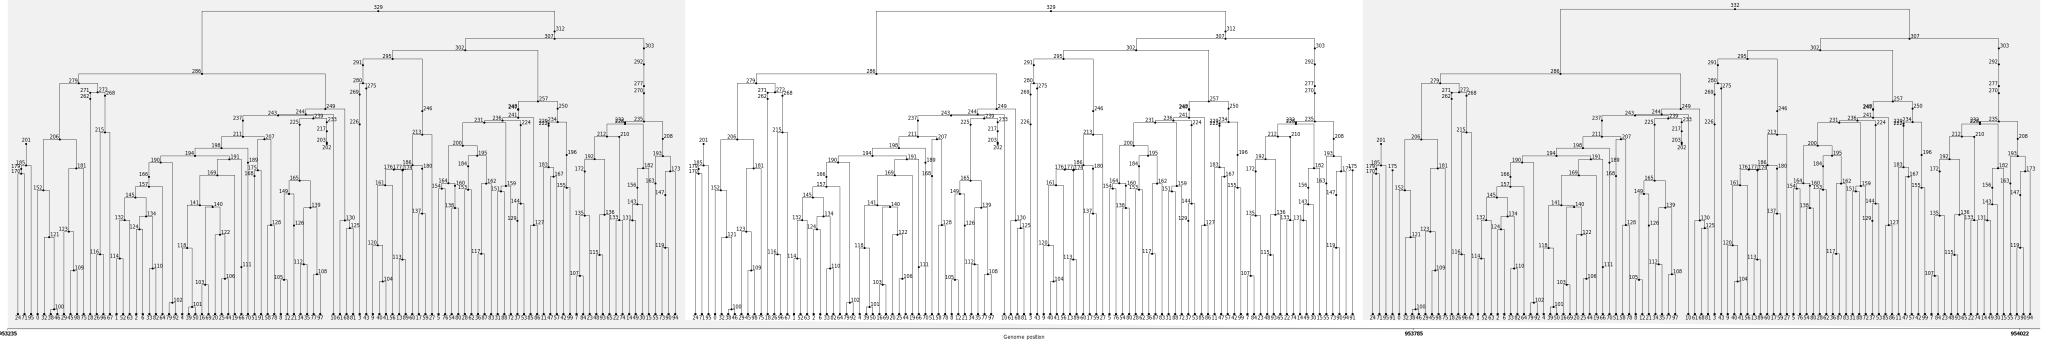

In [38]:
SVG(eets.draw_svg(x_lim = [953235,954030],size = (6000,1000), time_scale = 'log_time'))

big yikes here.
Look into $211 \to 207 \to 168 \to 51$. Large hop across trees for node $207$ and 168 does not follow in the case of $EE \to EP$.